In [1]:
from collections import defaultdict
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mptch
import matplotlib.gridspec as gridspec
import matplotlib.path as path
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy.interpolate import griddata

from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
from pyqstrat.pq_utils import set_defaults, ReasonCode, series_to_array, strtup2date, has_display, resample_ts, resample_trade_bars

set_defaults()

timestamps len: 4
o len: 4
h len: 4
l len: 4
c len: 4
v len: 4
vwap len: 4
slow_support ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'
 '2018-01-10T15:00:00.000000000' '2018-01-11T15:00:00.000000000']
fast_support ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'
 '2018-01-10T15:00:00.000000000' '2018-01-11T15:00:00.000000000']
slow_resistance ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'
 '2018-01-10T15:00:00.000000000' '2018-01-11T15:00:00.000000000']
fast_resistance ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'
 '2018-01-10T15:00:00.000000000' '2018-01-11T15:00:00.000000000']
price ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'
 '2018-01-10T15:00:00.000000000' '2018-01-11T15:00:00.000000000']
enter long ['2018-01-09T14:00:00.000000000']
exit long ['2018-01-10T15:00:00.000000000']
enter short ['2018-01-15T15:00:00.000000000']
trend ['2018-01-08T15:00:00.000000000' '2018-01-09T15:00:00.000000000'


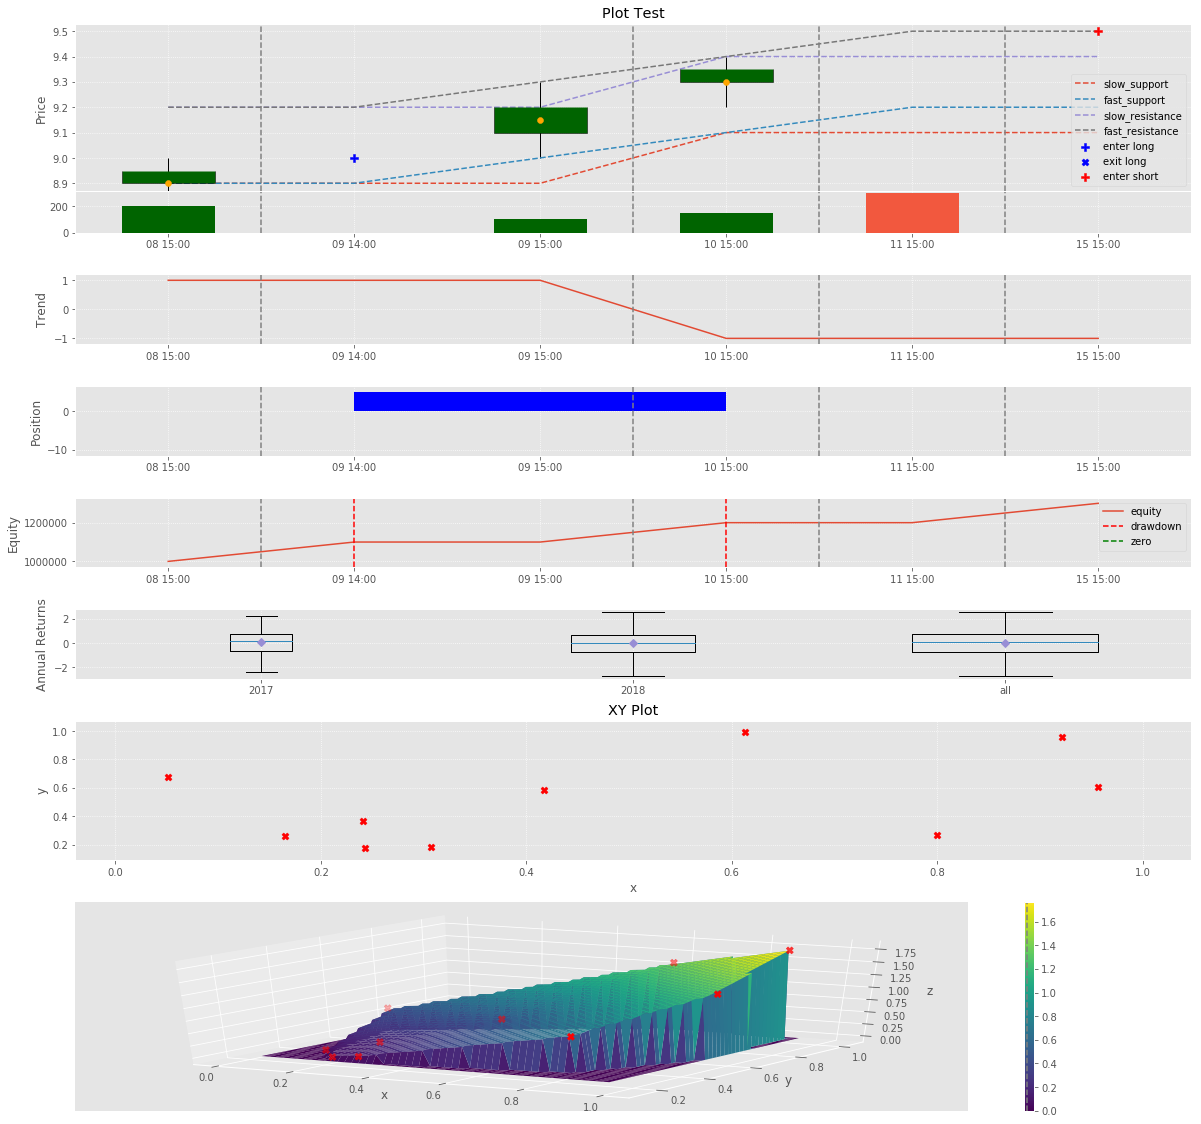

In [5]:

_VERBOSE = False

class DateFormatter(mtick.Formatter):
    '''
    Formats timestamps on plot axes.  See matplotlib Formatter
    '''
    def __init__(self, timestamps, fmt):
        self.timestamps = timestamps
        self.fmt = fmt

    def __call__(self, x, pos = 0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.timestamps) or ind < 0: return ''
        return mdates.num2date(self.timestamps[ind]).strftime(self.fmt)
    
class HorizontalLine:
    '''Draws a horizontal line on a subplot'''
    def __init__(self, y, name = None, line_type = 'dashed', color = None):
        self.y = y
        self.name = name
        self.line_type = line_type
        self.color = color
    
class VerticalLine:
    '''Draws a vertical line on a subplot where x axis is not a date-time axis'''
    def __init__(self, x, name = None, line_type = 'dashed', color = None):
        self.x = x
        self.name = name
        self.line_type = line_type
        self.color = color
    
class DateLine:
    '''Draw a vertical line on a plot with a datetime x-axis'''
    def __init__(self, date, name = None, line_type = 'dashed', color = None):
        self.date = date
        self.name = name
        self.line_type = line_type
        self.color = color
        
        
class BucketedValues:
    '''Data in a subplot where x axis is a categorical we summarize properties of a numpy array.  For example, drawing a boxplot with percentiles.'''
    def __init__(self, name, bucket_names, bucket_values, proportional_widths = True, show_means = True, show_all = True, show_outliers = False, notched = False):
        '''
        Args:
            name: name used for this data in a plot legend
            bucket_names: list of strings used on x axis labels
            bucket_values: list of numpy arrays that are summarized in this plot
            proportional_widths: if set to True, the width each box in the boxplot will be proportional to the number of items in its corresponding array
            show_means: Whether to display a marker where the mean is for each array
            show_outliers: Whether to show markers for outliers that are outside the whiskers.  
              Box is at Q1 = 25%, Q3 = 75% quantiles, whiskers are at Q1 - 1.5 * (Q3 - Q1), Q3 + 1.5 * (Q3 - Q1)
            notched: Whether to show notches indicating the confidence interval around the median
        '''
        assert isinstance(bucket_names, list) and isinstance(bucket_values, list) and len(bucket_names) == len(bucket_values)
        self.name = name
        self.bucket_names = bucket_names
        self.bucket_values = series_to_array(bucket_values)
        self.plot_type = 'boxplot'
        self.proportional_widths = proportional_widths
        self.show_means = show_means
        self.show_all = show_all
        self.show_outliers = show_outliers
        self.notched = notched
        self.time_plot = False
        
class XYData:
    '''
    Data in a subplot that has x and y values that are both arrays of floats
    
    '''
    def __init__(self, name, x, y, plot_type = 'line', line_type = 'solid', line_width = None, color = None, marker = None, marker_size = 50,
                 marker_color = 'red'):
        '''
        Args:
            x: pandas series or numpy array of floats
            y: pandas series or numpy arry of floats
        '''
        self.name = name
        self.x = series_to_array(x)
        self.y = series_to_array(y)
        self.plot_type = plot_type
        if plot_type == 'scatter' and marker is None: marker = 'X'
        self.line_type = line_type
        self.line_width = line_width
        self.color = color
        self.marker = marker
        self.marker_size = marker_size
        self.marker_color = marker_color
        self.time_plot = False
        
class XYZData:
    '''Data in a subplot that has x, y and z values that are all floats'''
    def __init__(self, name, x, y, z, plot_type = 'surface', marker = 'X', marker_size = 50, marker_color = 'red', interpolation = 'linear',  cmap = 'viridis'):
        '''
        Args:
            x: pandas series or numpy array of floats
            y: pandas series or numpy array of floats
            z: pandas series or numpy array of floats
            plot_type: surface or contour (default surface)
            marker: Adds a marker to each point in x, y, z to show the actual data used for interpolation.  You can set this to None to turn markers off.
            interpolation: Can be ‘linear’, ‘nearest’ or ‘cubic’ for plotting z points between the ones passed in.  See scipy.interpolate.griddata for details
            cmap: Colormap to use (default viridis).  See matplotlib colormap for details
        '''
        self.name = name
        self.x = x
        self.y = y
        self.z = z
        self.plot_type = plot_type
        self.marker = marker
        self.marker_size = marker_size
        self.marker_color = marker_color
        self.interpolation = interpolation
        self.cmap = cmap
        self.time_plot = False
    
class TimeSeries:
    '''Data in a subplot where x is an array of numpy datetimes and y is a numpy array of floats'''
    def __init__(self, name, timestamps, values, plot_type = 'line', line_type = 'solid', line_width = None, color = None, marker = None, marker_size = 50,
                 marker_color = 'red'):
        '''Args:
            name: Name to show in plot legend
            timestamps: pandas Series or numpy array of datetime64
            values: pandas Series or numpy array of floats
            plot_type: 'line' or 'scatter'
            marker: If set, show a marker at each value in values.  See matplotlib marker types
        '''
        self.name = name
        self.timestamps = series_to_array(timestamps)
        self.values = series_to_array(values)
        self.plot_type = plot_type
        self.line_type = line_type
        self.color = color
        self.line_width = line_width
        if plot_type == 'scatter' and marker is None: raise Exception('marker must be set for plot_type scatter')
        self.marker = marker
        self.marker_size = marker_size
        self.marker_color = marker_color
        self.time_plot = True
        
    def reindex(self, timestamps, fill):
        '''Reindex this series given a new array of timestamps, forward filling holes if fill is set to True'''
        s = pd.Series(self.values, index = self.timestamps)
        s = s.reindex(timestamps, method = 'ffill' if fill else None)
        self.timestamps = s.index.values
        self.values = s.values
        
class TradeBarSeries:
    '''
    Data in a subplot that contains open, high, low, close, volume bars.  volume is optional.
    '''
    def __init__(self, name, timestamps, o, h, l, c, v = None, vwap = None, colorup='darkgreen', colordown='#F2583E'):
        '''
        Args:
            name: Name to show in a legend
            colorup: Color for bars where close >= open.  Default "darkgreen"
            colordown: Color for bars where open < close.  Default "#F2583E"
        '''
        self.name = name
        self.timestamps = timestamps
        self.o = o
        self.h = h
        self.l = l
        self.c = c
        self.v = np.ones(len(self.timestamps), dtype = np.float64) * np.nan if v is None else v
        self.vwap = np.ones(len(self.timestamps), dtype = np.float64) * np.nan if vwap is None else vwap
        self.plot_type = 'candlestick'
        self.colorup = colorup
        self.colordown = colordown
        self.time_plot = True
        
    def df(self):
        return pd.DataFrame({'o' : self.o, 'h' : self.h, 'l' : self.l, 'c' : self.c, 'v' : self.v, 'vwap' : self.vwap}, index = self.timestamps)[['o', 'h', 'l', 'c', 'v', 'vwap']]
        
    def reindex(self, all_timestamps):
        df = self.df()
        df = df.reindex(all_timestamps)
        self.timestamps = all_timestamps
        for col in df.columns:
            setattr(self, col, df[col].values)
                
class TradeSet:
    '''Data for subplot that contains a set of trades along with marker properties for these trades'''
    def __init__(self, name, trades, marker = 'P', marker_color = None, marker_size = 50):
        '''
        Args:
            name: String to display in a subplot legend
            trades: List of Trade objects to plot
        '''
        self. name = name
        self.trades = trades
        self.plot_type = 'scatter'
        self.marker = marker
        self.marker_color = marker_color
        self.marker_size = marker_size
        self.timestamps = np.array([trade.timestamp for trade in trades], dtype = 'M8[ns]')
        self.values = np.array([trade.price for trade in trades], dtype = np.float)
        self.time_plot = True
        
    def reindex(self, all_timestamps, fill):
        s = pd.Series(self.values, index = self.timestamps)
        s = s.reindex(all_timestamps, method = 'ffill' if fill else None)
        self.timestamps = s.index.values
        self.values = s.values
        
    def __repr__(self):
        s = ''
        for trade in self.trades:
            s += f'{trade.timestamp} {trade.qty} {trade.price}\n'
        return s
    
def draw_poly(ax, left, bottom, top, right, facecolor, edgecolor, zorder):
    '''Draw a set of polygrams given parrallel numpy arrays of left, bottom, top, right points'''
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    barpath = path.Path.make_compound_path_from_polys(XY)
    
    # Clean path to get rid of 0, 0 points.  Seems to be a matplotlib bug.  If we don't ylim lower bound is set to 0
    v = []
    c = []
    for seg in barpath.iter_segments():
        vertices, command = seg
        if not (vertices[0] == 0. and vertices[1] == 0.):
            v.append(vertices)
            c.append(command)
    cleaned_path = path.Path(v, c)

    patch = mptch.PathPatch(cleaned_path, facecolor = facecolor, edgecolor = edgecolor, zorder = zorder)
    ax.add_patch(patch)


def draw_candlestick(ax, index, o, h, l, c, v, vwap, colorup='darkgreen', colordown='#F2583E'):
    '''Draw candlesticks given parrallel numpy arrays of o, h, l, c, v values.  v is optional.  
    See TradeBarSeries class __init__ for argument descriptions.'''
    width = 0.5
                
    if v is not None and not np.isnan(v).all(): # Have to do volume first because of a mpl bug with axes fonts if we use make_axes_locatable after plotting on top axis
        divider = make_axes_locatable(ax)
        vol_ax = divider.append_axes('bottom', size = '25%', sharex = ax)
        _c = np.nan_to_num(c)
        _o = np.nan_to_num(o)
        pos = _c >= _o
        neg = _c < _o
        vol_ax.bar(index[pos], v[pos], color = colorup, width = width)
        vol_ax.bar(index[neg], v[neg], color= colordown, width = width)
    
    offset = width / 2.0
    
    mask = ~np.isnan(c) & ~np.isnan(o)
    mask[mask] &= c[mask] < o[mask]
    
    left = index - offset
    bottom = np.where(mask, o, c)
    top = np.where(mask, c, o)
    right = left + width
    
    draw_poly(ax, left[mask], bottom[mask], top[mask], right[mask], colordown, 'k', 100)
    draw_poly(ax, left[~mask], bottom[~mask], top[~mask], right[~mask], colorup, 'k', 100)
    draw_poly(ax, left + offset, l, h, left + offset, 'k', 'k', 1)
    if vwap is not None:
        ax.scatter(index, vwap, marker = 'o', color = 'orange', zorder = 110)
        
def draw_boxplot(ax, names, values, proportional_widths = True, notched = False, show_outliers = True, show_means = True, show_all = True):
    '''Draw a boxplot.  See BucketedValues class for explanation of arguments'''
    outliers = None if show_outliers else ''
    meanpointprops = dict(marker='D')
    assert(isinstance(values, list) and isinstance(names, list) and len(values) == len(names))
    widths = None
    
    if show_all:
        all_values = np.concatenate(values)
        values.append(all_values)
        names.append('all')
    
    if proportional_widths:
        counts = [len(v) for v in values]
        total = float(sum(counts))
        cases = len(counts)
        widths = [c/total for c in counts]  
    
    ax.boxplot(values, notch = notched, sym = outliers, showmeans = show_means, meanprops=meanpointprops, widths = widths) #, widths = proportional_widths);
    ax.set_xticklabels(names);
    
    
def draw_3d_plot(ax, x, y, z, plot_type, marker = 'X', marker_size = 50, marker_color = 'red',
                interpolation = 'linear', cmap = 'viridis'):

    '''Draw a 3d plot.  See XYZData class for explanation of arguments
    
    >>> points = np.random.rand(1000, 2)
    >>> x = np.random.rand(10)
    >>> y = np.random.rand(10)
    >>> z = x ** 2 + y ** 2
    >>> if has_display():
    ...    fig, ax = plt.subplots()
    ...    draw_3d_plot(ax, x = x, y = y, z = z, plot_type = 'contour', interpolation = 'linear')
    '''
    xi = np.linspace(min(x), max(x))
    yi = np.linspace(min(y), max(y))
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (xi[None,:], yi[:,None]), method=interpolation)
    Z = np.nan_to_num(Z)

    if plot_type == 'surface':
        ax.plot_surface(X, Y, Z, cmap = cmap)
        if marker is not None:
            ax.scatter(x, y, z, marker = marker, s = marker_size, c = marker_color)
    elif plot_type == 'contour':
        cs = ax.contour(X, Y, Z, linewidths = 0.5, colors='k')
        ax.clabel(cs, cs.levels[::2], fmt = "%.3g", inline=1)
        ax.contourf(X, Y, Z, cmap = cmap)
        if marker is not None:
            ax.scatter(x, y, marker = marker, s = marker_size, c = marker_color, zorder=10)
    else:
        raise Exception(f'unknown plot type: {plot_type}')

    m = cm.ScalarMappable(cmap = cmap)
    m.set_array(Z)
    plt.colorbar(m, ax = ax)
    
def _adjust_axis_limit(lim, values):
    '''If values + 10% buffer are outside current xlim or ylim, return expanded xlim or ylim for subplot'''
    min_val, max_val = min(values), max(values)
    lim_min = min(values) - .1 * (max_val - min_val)
    lim_max = max(values) + .1 * (max_val - min_val)
    return (min(lim[0], lim_min), max(lim[1], lim_max))

def _plot_data(ax, data):
    
    x, y = None, None
    
    if data.time_plot:
        timestamps = data.timestamps
        x = np.arange(len(timestamps))

    if hasattr(data, 'x'): x = data.x
    if hasattr(data, 'values'): y = data.values
    elif hasattr(data, 'y'): y = data.y
        
    line = None
    
    if data.plot_type == 'line':
        line, = ax.plot(x, y, linestyle = data.line_type, linewidth = data.line_width, color = data.color)
        if data.marker is not None:
            line = ax.scatter(x, y, marker = data.marker, c = data.marker_color, s = data.marker_size, zorder=100)
    elif data.plot_type == 'scatter':
        line = ax.scatter(x, y, marker = data.marker, c = data.marker_color, s = data.marker_size, zorder=100)
    elif data.plot_type == 'bar':
        line = ax.bar(index, y, color = data.color)
    elif data.plot_type == 'filled_line':
        values = np.nan_to_num(data.values)
        pos_values = np.where(y > 0, y, 0)
        neg_values = np.where(y < 0, y, 0)
        ax.fill_between(x, pos_values, color='blue', step = 'post', linewidth = 0.0)
        ax.fill_between(x, neg_values, color='red', step = 'post', linewidth = 0.0)
        #ax.set_ylim(max(ylim[0], np.max(y) * 1.1), min(ylim[1], np.min(y) * 1.1))
    elif data.plot_type == 'candlestick':
        draw_candlestick(ax, x, data.o, data.h, data.l, data.c, data.v, data.vwap, colorup = data.colorup, colordown = data.colordown)
    elif data.plot_type == 'boxplot':
        draw_boxplot(ax, data.bucket_names, data.bucket_values, data.proportional_widths, data.notched, data.show_outliers, 
                     data.show_means, data.show_all)
    elif data.plot_type in ['contour', 'surface']:
        draw_3d_plot(ax, x, y, data.z, data.plot_type, data.marker, data.marker_size,
                     data.marker_color, data.interpolation, data.cmap)
    else:
        raise Exception(f'unknown plot type: {data.plot_type}')
        
    # For scatter and filled line, xlim and ylim does not seem to get set automatically
    if x is not None: ax.set_xlim(_adjust_axis_limit(ax.get_xlim(), x))
    if y is not None: ax.set_ylim(_adjust_axis_limit(ax.get_ylim(), y))

    return line

def _draw_date_gap_lines(ax, plot_timestamps):
    timestamps = mdates.date2num(plot_timestamps)
    freq = np.nanmin(np.diff(timestamps))
    if freq <= 0: raise Exception('could not infer date frequency')
    date_index = np.arange(len(timestamps))
    date_diff = np.diff(timestamps)
    
    xs = []

    for i in date_index:
        if i < len(date_diff) and date_diff[i] > (freq + 0.000000001):
            xs.append(i + 0.5)
            
    if len(xs) > 20:
        return # Too many lines will clutter the graph
    
    for x in xs:
        ax.axvline(x, linestyle = 'dashed', color = '0.5')
            
def draw_date_line(ax, plot_timestamps, date, linestyle, color):
    '''Draw vertical line on a subplot with datetime x axis'''
    date_index = np.arange(len(plot_timestamps))
    closest_index = (np.abs(plot_timestamps - date)).argmin()
    return ax.axvline(x = closest_index, linestyle = linestyle, color = color)

def draw_horizontal_line(ax, y, linestyle, color):
    '''Draw horizontal line on a subplot'''
    return ax.axhline(y = y, linestyle = linestyle, color = color)

def draw_vertical_line(ax, x, linestyle, color):
    '''Draw vertical line on a subplot'''
    return ax.axvline(x = x, linestyle = linestyle, color = color)
           
def get_date_formatter(plot_timestamps, date_format):
    '''Create an appropriate DateFormatter for x axis labels.  
    If date_format is set to None, figures out an appropriate date format based on the range of timestamps passed in'''
    num_timestamps = mdates.date2num(plot_timestamps)
    if date_format is not None: return DateFormatter(num_timestamps, format = date_format)
    date_range = num_timestamps[-1] - num_timestamps[0]
    if date_range > 252:
        date_format = '%d-%b-%Y'
    elif date_range > 7:
        date_format = '%b %d'
    elif date_range > 1:
        date_format = '%d %H:%M'
    else:
        date_format = '%H:%M:%S'
        
    formatter = DateFormatter(num_timestamps, fmt = date_format)
    return formatter
    
class Subplot:
    '''A top level plot contains a list of subplots, each of which contain a list of data objects to draw'''
    def __init__(self, data_list, title = None, xlabel = None, ylabel = None, zlabel = None,
                 date_lines = None, horizontal_lines = None, vertical_lines = None, xlim = None, ylim = None, 
                 height_ratio = 1.0, display_legend = True, legend_loc = 'best', log_y = False, y_tick_format = None):
        
        '''
        Args:
            data_list: A list of objects to draw.  Each element can contain XYData, XYZData, TimeSeries, TradeBarSeries, BucketedValues or TradeSet
            title: Title to show for this subplot. Default None
            zlabel: Only applicable to 3d subplots.  Default None
            date_lines: A list of DateLine objects to draw as vertical lines.  Only applicable when x axis is datetime.  Default None
            horizontal_lines: A list of HorizontalLine objects to draw on the plot.  Default None
            vertical_lines: A list of VerticalLine objects to draw on the plot
            xlim: x limits for the plot as a tuple of numpy datetime objects when x-axis is datetime, or tuple of floats. Default None
            ylim: y limits for the plot.  Tuple of floats.  Default None
            height_ratio: If you have more than one subplot on a plot, use height ratio to determine how high each subplot should be.
                For example, if you set height_ratio = 0.75 for the first subplot and 0.25 for the second, 
                the first will be 3 times taller than the second one. Default 1.0
            display_legend: Whether to show a legend on the plot.  Default True
            legend_loc: Location for the legend. Default 'best'
            log_y: whether the y axis should be logarithmic.  Default False
            y_tick_format: Format string to use for y axis labels.  For example, you can decide to 
              use fixed notation instead of scientific notation or change number of decimal places shown.  Default None
        '''
        if not isinstance(data_list, list): data_list = [data_list]
        self.time_plot = all([data.time_plot for data in data_list])
        if self.time_plot and any([not data.time_plot for data in data_list]):
            raise Exception('cannot add a non date subplot on a subplot which has time series plots')
        if not self.time_plot and date_lines is not None: 
            raise Exception('date lines can only be specified on a time series subplot')
        
        self.is_3d = any([data.plot_type in ['surface'] for data in data_list])
        if self.is_3d and any([data.plot_type not in ['surface'] for data in data_list]):
            raise Exception('cannot add a 2d plot on a subplot which has a 3d plot')

        self.data_list = data_list
        self.date_lines = [] if date_lines is None else date_lines
        self.horizontal_lines = [] if horizontal_lines is None else horizontal_lines
        self.vertical_lines = [] if vertical_lines is None else vertical_lines
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.zlabel = zlabel
        self.ylim = ylim
        self.height_ratio = height_ratio
        self.display_legend = display_legend
        self.legend_loc = legend_loc
        self.log_y = log_y
        self.y_tick_format = y_tick_format
        
    def _resample(self, sampling_frequency):
        timestamps, values = None, None
        for data in self.data_list:
            values = None
            if isinstance(data, TimeSeries) or isinstance(data, TradeSet):
                data.timestamps, data.values = resample_ts(data.timestamps, data.values, sampling_frequency)
            elif isinstance(data, TradeBarSeries):
                df_dict = {}
                cols = ['timestamps', 'o', 'h', 'l' , 'c', 'v', 'vwap']
                for col in cols:
                    val = getattr(data, col)
                    if val is not None:
                        df_dict[col] = val
                df = pd.DataFrame(df_dict)
                df.set_index('timestamps', inplace = True)
                df = resample_trade_bars(df, sampling_frequency)
                for col in cols:
                    if col in df:
                        setattr(data, col, df[col].values)
            else:
                raise Exception(f'unknown type: {data}')
        
    def get_all_timestamps(self, date_range):
        timestamps_list = [data.timestamps for data in self.data_list]
        all_timestamps = np.array(reduce(np.union1d, timestamps_list))
        if date_range: all_timestamps = all_timestamps[(all_timestamps >= date_range[0]) & (all_timestamps <= date_range[1])]
        return all_timestamps
    
    def _reindex(self, all_timestamps):
        for data in self.data_list:
            if isinstance(data, TradeBarSeries):
                data.reindex(all_timestamps)
            else:
                fill = not isinstance(data, TradeSet) and not data.plot_type in ['bar', 'scatter']
                data.reindex(all_timestamps, fill = fill)
            
    def _draw(self, ax, plot_timestamps, date_formatter):
        
        if self.time_plot:
            self._reindex(plot_timestamps)
            ax.xaxis.set_major_formatter(date_formatter)
            date_index = np.arange(len(plot_timestamps))
        
        lines = []
        
        for data in self.data_list:
            if _VERBOSE: print(f'plotting data: {data.name}')
            line  = _plot_data(ax, data)
            lines.append(line)
            
        for date_line in self.date_lines: # vertical lines on time plot
            line = draw_date_line(ax, plot_timestamps, date_line.date, date_line.line_type, date_line.color)
            if date_line.name is not None: lines.append(line)
                
        for horizontal_line in self.horizontal_lines:
            line = draw_horizontal_line(ax, horizontal_line.y, horizontal_line.line_type, horizontal_line.color)
            if horizontal_line.name is not None: lines.append(line)
                
        for vertical_line in self.vertical_lines:
            line = draw_vertical_line(ax, vertical_line.x, vertical_line.line_type, vertical_line.color)
            if vertical_line.name is not None: lines.append(line)
          
        self.legend_names = [data.name for data in self.data_list]
        self.legend_names += [date_line.name for date_line in self.date_lines if date_line.name is not None]
        self.legend_names += [horizontal_line.name for horizontal_line in self.horizontal_lines if horizontal_line.name is not None]
        self.legend_names += [vertical_line.name for vertical_line in self.vertical_lines if vertical_line.name is not None]
        
        if self.ylim: ax.set_ylim(self.ylim)
        if (len(self.data_list) > 1 or len(self.date_lines)) and self.display_legend: 
            ax.legend([line for line in lines if line is not None],
                      [self.legend_names[i] for i, line in enumerate(lines) if line is not None], loc = self.legend_loc)
 
        if self.log_y: 
            ax.set_yscale('log')
            ax.yaxis.set_major_locator(mtick.AutoLocator())
        if self.y_tick_format:
            ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(self.y_tick_format))
            
        ax.relim()
        ax.autoscale_view()
        
        if self.title: ax.set_title(self.title)
        if self.xlabel: ax.set_xlabel(self.xlabel)
        if self.ylabel: ax.set_ylabel(self.ylabel)
        if self.zlabel: ax.set_zlabel(self.zlabel)
            
class Plot:
    
    '''Top level plot containing a list of subplots to draw'''
    
    def __init__(self, subplot_list,  title = None, figsize = (15, 8), date_range = None, date_format = None, 
                 sampling_frequency = None, show_grid = True, show_date_gaps = True, hspace = 0.15):
        '''
        Args:
            subplot_list: List of Subplot objects to draw
            title: Title for this plot.  Default None
            figsize: Figure size.  Default (15, 8)
            date_range: Tuple of strings or numpy datetime64 limiting timestamps to draw.  e.g. ("2018-01-01 14:00", "2018-01-05"). Default None
            date_format: Date format to use for x-axis
            sampling_frequency: Set this to downsample subplots that have a datetime x axis.  
              For example, if you have minute bar data, you might want to subsample to hours if the plot is too crowded.
              See pandas time frequency strings for possible values.  Default None
            show_grid: If set to True, show a grid on the subplots.  Default True
            show_date_gaps: If set to True, then when there is a gap between timestamps will draw a dashed vertical line. 
              For example, you may have minute bars and a gap between end of trading day and beginning of next day. 
              Even if set to True, this will turn itself off if there are too many gaps to avoid clutter.  Default True
            hspace: Height (vertical) space between subplots.  Default 0.15
        '''
        if isinstance(subplot_list, Subplot): subplot_list = [subplot_list]
        assert(len(subplot_list))
        self.subplot_list = subplot_list
        self.title = title
        self.figsize = figsize
        self.date_range = strtup2date(date_range)
        self.date_format = date_format
        self.sampling_frequency = sampling_frequency
        self.show_date_gaps = show_date_gaps
        self.show_grid = show_grid
        self.hspace = hspace
        
    def _get_plot_timestamps(self):
        timestamps_list = []
        for subplot in self.subplot_list:
            if not subplot.time_plot: continue
            subplot._resample(self.sampling_frequency)
            timestamps_list.append(subplot.get_all_timestamps(self.date_range))
        if not len(timestamps_list): return None
        plot_timestamps = np.array(reduce(np.union1d, timestamps_list))
        return plot_timestamps
        

    def draw(self, check_data_size = True):
        '''Draw the subplots.
        
        Args:
            check_data_size: If set to True, will not plot if there are > 100K points to avoid locking up your computer for a long time.
              Default True
        '''
        if not has_display():
            print('no display found, cannot plot')
            return
        
        plot_timestamps = self._get_plot_timestamps()
        if check_data_size and plot_timestamps is not None and len(plot_timestamps) > 100000:
            raise Exception(f'trying to plot large data set with {len(plot_timestamps)} points, reduce date range or turn check_data_size flag off')
            
        date_formatter = None
        if plot_timestamps is not None: 
            date_formatter = get_date_formatter(plot_timestamps, self.date_format)
        height_ratios = [subplot.height_ratio for subplot in self.subplot_list]
        
        fig = plt.figure(figsize = self.figsize)
        gs = gridspec.GridSpec(len(self.subplot_list), 1, height_ratios= height_ratios, hspace = self.hspace)
        axes = []
        
        for i, subplot in enumerate(self.subplot_list):
            if subplot.is_3d:
                ax = plt.subplot(gs[i], projection='3d')
            else:
                ax = plt.subplot(gs[i])
            axes.append(ax)
            
        time_axes = [axes[i] for i, s in enumerate(self.subplot_list) if s.time_plot]
        if len(time_axes):
            time_axes[0].get_shared_x_axes().join(*time_axes)
            
        for i, subplot in enumerate(self.subplot_list):
            subplot._draw(axes[i], plot_timestamps, date_formatter)
            
        if self.title: axes[0].set_title(self.title)

        # We may have added new axes in candlestick plot so get list of axes again
        ax_list = fig.axes
        for ax in ax_list:
            if self.show_grid: ax.grid(linestyle='dotted') #, color = 'grey', which = 'both', alpha = 0.5)
                
        for ax in ax_list:
            if ax not in axes: time_axes.append(ax)
                
        for ax in time_axes:
            if self.show_date_gaps and plot_timestamps is not None: _draw_date_gap_lines(ax, plot_timestamps)
                
        for ax in ax_list:
            ax.relim()
            ax.autoscale_view()
            
        return ax_list
                
def _group_trades_by_reason_code(trades):
    trade_groups = defaultdict(list)
    for trade in trades:
        trade_groups[trade.order.reason_code].append(trade)
    return trade_groups

def trade_sets_by_reason_code(trades, marker_props = ReasonCode.MARKER_PROPERTIES):
    '''
    Returns a list of TradeSet objects.  Each TradeSet contains trades with a different reason code.  The markers for each TradeSet
    are set by looking up marker properties for each reason code using the marker_props argument:
    
    Args:
        trades: List of Trade objects, each containing an order attribute which in turn contains a reason_code attribute
        marker_props: Dictionary from reason code string -> dictionary of marker properties.  See ReasonCode.MARKER_PROPERTIES for example.
          Default ReasonCode.MARKER_PROPERTIES
     '''
    trade_groups = _group_trades_by_reason_code(trades)
    tradesets = []
    for reason_code, trades in trade_groups.items():
        if reason_code in marker_props:
            mp = marker_props[reason_code]
            tradeset = TradeSet(reason_code, trades, marker = mp['symbol'], marker_color = mp['color'], marker_size = mp['size'])
        else:
            tradeset = TradeSet(reason_code, trades)
        tradesets.append(tradeset)
    return tradesets 

def test_plot():
    
    class MockOrder:
        def __init__(self, reason_code):
            self.reason_code = reason_code
    
    class MockTrade:
        def __init__(self, timestamp, qty, price, reason_code):
            self.timestamp = timestamp
            self.qty = qty
            self.price = price
            self.order = MockOrder(reason_code) 
            
        def __repr__(self):
            return f'{self.date} {self.qty} {self.price}'
        
    set_defaults()
            
    timestamps = np.array(['2018-01-08 15:00:00', '2018-01-09 15:00:00', '2018-01-10 15:00:00', '2018-01-11 15:00:00'], dtype = 'M8[ns]')
    pnl_timestamps = np.array(['2018-01-08 15:00:00', '2018-01-09 14:00:00', '2018-01-10 15:00:00', '2018-01-15 15:00:00'], dtype = 'M8[ns]')
    
    positions = (pnl_timestamps, np.array([0., 5., 0.,-10.]))
    
    trade_timestamps = np.array(['2018-01-09 14:00:00', '2018-01-10 15:00:00', '2018-01-15 15:00:00'], dtype = 'M8[ns]')
    trade_price = [9., 10., 9.5]
    trade_qty =  [5, -5, -10]
    reason_codes = [ReasonCode.ENTER_LONG, ReasonCode.EXIT_LONG, ReasonCode.ENTER_SHORT]
    trades = [MockTrade(trade_timestamps[i], trade_qty[i], trade_price[i], reason_codes[i]) for i, d in enumerate(trade_timestamps)]

    ind_subplot = Subplot([TimeSeries('slow_support', timestamps = timestamps, values = np.array([8.9, 8.9, 9.1, 9.1]), line_type = '--'),
                           TimeSeries('fast_support', timestamps = timestamps, values = np.array([8.9, 9.0, 9.1, 9.2]), line_type = '--'),
                           TimeSeries('slow_resistance', timestamps = timestamps, values = np.array([9.2, 9.2, 9.4, 9.4]), line_type = '--'),
                           TimeSeries('fast_resistance', timestamps = timestamps, values = np.array([9.2, 9.3, 9.4, 9.5]), line_type = '--'), 
                           TradeBarSeries('price', timestamps = timestamps, 
                                o = np.array([8.9, 9.1, 9.3, 8.6]),
                                h = np.array([9.0, 9.3, 9.4, 8.7]),
                                l = np.array([8.8, 9.0, 9.2, 8.4]),
                                c = np.array([8.95, 9.2, 9.35, 8.5]),
                                v = np.array([200, 100, 150, 300]),
                                vwap = np.array([8.9, 9.15, 9.3, 8.55]))
                          ] + trade_sets_by_reason_code(trades), ylabel = "Price", height_ratio = 0.3)
    
    sig_subplot = Subplot(TimeSeries('trend', timestamps = timestamps, values = np.array([1, 1, -1, -1])), height_ratio=0.1, ylabel = 'Trend')
    
    equity_subplot = Subplot(TimeSeries('equity', timestamps= pnl_timestamps, values = [1.0e6, 1.1e6, 1.2e6, 1.3e6]), height_ratio = 0.1, ylabel = 'Equity', date_lines = 
                            [DateLine(date = np.datetime64('2018-01-09 14:00:00'), name = 'drawdown', color = 'red'),
                             DateLine(date = np.datetime64('2018-01-10 15:00:00'), color = 'red')], 
                             horizontal_lines = [HorizontalLine(y = 0, name = 'zero', color = 'green')])
    
    pos_subplot = Subplot(TimeSeries('position', timestamps = positions[0], values = positions[1], plot_type = 'filled_line'), height_ratio = 0.1, ylabel = 'Position')
    
    annual_returns_subplot = Subplot(BucketedValues('annual returns', ['2017', '2018'], 
                                                    bucket_values = [np.random.normal(0, 1, size=(250,)), np.random.normal(0, 1, size=(500,))]),
                                                   height_ratio = 0.1, ylabel = 'Annual Returns')
    
    x = np.random.rand(10)
    y = np.random.rand(10)
    xy_subplot = Subplot(XYData('2d test', x, y, plot_type = 'scatter', marker = 'X'), xlabel = 'x', ylabel = 'y', height_ratio = 0.2, title = 'XY Plot')
    
    z = x ** 2 + y ** 2
    xyz_subplot = Subplot(XYZData('3d test', x, y, z, ), xlabel = 'x', ylabel = 'y', zlabel = 'z', height_ratio = 0.3)
    
    
    subplot_list = [ind_subplot, sig_subplot, pos_subplot, equity_subplot, annual_returns_subplot, xy_subplot, xyz_subplot]
    plot = Plot(subplot_list, figsize = (20,20), title = 'Plot Test', hspace = 0.35)
    plot.draw();
    
if __name__ == "__main__":
    test_plot();